<a href="https://colab.research.google.com/github/alessiodevoto/NeuralNetworks_project/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and framework

In [ ]:
%%capture
!python -c "import torch; print(torch.__version__)"
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install torch-geometric
!pip install wget
!pip install pickle5
!pip install pytorch-metric-learning[with-hooks]
!pip install -U catalyst
!pip install metric-learn

In [ ]:
cd /content/drive/MyDrive/gcn2

/content/drive/MyDrive/gcn2


# Data and Model

We load our data into train and validation set. 
We use here the pre_split option in the constructor, to download same train-val dataset split as was used to train their model.

(Remember that bbox and edges are automatically normalized dividing by largest bbox and largest edge in dataset, unless we specify normlize_edges and normalize_bboxs = False)


In [ ]:
%matplotlib inline
from PoleDataset import PoleDataset
import torch
import numpy as np
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
import utils, config
from pytorch_metric_learning import losses, miners, reducers, regularizers, samplers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

# DATA LOADING
# Training data
train_data = PoleDataset(root='train_data',
                         password='matching',
                         pre_split='train',
                         edge_range=(0.0001, 0.06), 
                         bbox_threshold= 0.001)
train_data.info(plots=False)

# Validation data
val_data = PoleDataset(root='val_data',
                       password='matching',
                       pre_split='val',
                       edge_range=(0.0001, 0.06),
                       bbox_threshold=0.001)
val_data.info(plots=False)

We now use pytorch metric learning library to mine triplets to be fed to the net. 
Note: from now on we use "target" or "class" to refere to the pylon id, because we can see the photos capturing the same pylon as beloging to the same class. 

We are going to define:
- A sampler, that creates batches of size config.batch_size (64) according to specific rules. (m is the number of samples of each class that should show up in each batch) 
- A dataloader, which is nothing but a plain Pytorch dataloader
- A miner, that selects on wich triplets the loss function should be used, once the embeddings are already computed
- A loss function, that works with triplets
- A reducer, that computes a reduction of the loss function to a scalar (e.g. computing the mean)

In [13]:
import single_network

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Samplers (data miners)
# This sampler extracts m elements of each class (i.e. capturing the same pylon) 
batch_size = config.batch_size
train_labels = torch.cat([elem.y for elem in train_data])
train_sampler = samplers.MPerClassSampler(labels=train_labels, m=4, batch_size=config.batch_size)

# Dataloaders
train_loader = DataLoader(train_data, batch_size=config.batch_size, sampler=train_sampler)
val_loader = DataLoader(val_data, batch_size=config.batch_size)

"""LOSS SETTINGS"""
miner = miners.BatchEasyHardMiner()
reducer = reducers.MeanReducer()
# reducer = reducers.AvgNonZeroReducer()
criterion = losses.TripletMarginLoss(reducer=reducer)

"""GENERAL TRAINING SETTINGS and MODEL"""
learning_rate = 0.0001
num_epochs = 10

model = single_network.SingleGraphEmbeddingNet(config.get_network_settings())
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

Built model with following settings:
{'num_categories': 49, 'categorical_embedding_dim': 8, 'linear_embedding_layers': [52], 'convolutional_layers': [64, 64], 'concat_convolutions': True, 'aggregator_out_dim': 72, 'pooling': None, 'kernel_size': 3, 'stride': 2, 'padding': 0}
SingleGraphEmbeddingNet(
  (embedding_net): NodeFeaturesEmbedding(
    (categorical_embedding): Embedding(49, 8)
    (linear_embedding): Sequential(
      (0): Linear(in_features=11, out_features=52, bias=True)
      (1): ReLU()
    )
  )
  (convolutions): MessageNet(
    (conv1): GCNConv(52, 64)
    (conv2): GCNConv(64, 64)
  )
  (aggregator): GraphAggregator(
    (aggregator): Linear(in_features=128, out_features=72, bias=True)
  )
)


We can now define the training and validation routine. 

In [14]:
# Training routine for one epoch

def train_epoch(epoch, train_loader):
    # Training
    model.train()
    train_losses = []
    for i, batch in enumerate(train_loader):
        x, edge_index, edge_attr, y, batch_map = batch.x.to(device), batch.edge_index.to(device), batch.edge_attr.to(
            device), batch.y.to(device), batch.batch.to(device)
        # Get the embedding for each graph in batch:    
        embeddings = model(x, edge_index, batch_map)
        embedding = F.normalize(embeddings) 
        # Select hardest embeddings:   
        mined_embeddings = miner(embeddings, y) if miner is not None else None
        # Compute the loss:
        train_loss = criterion(embeddings, y, mined_embeddings)  
        train_losses.append(train_loss)
        # Derive, update and clear gradients:
        train_loss.backward()  
        optimizer.step() 
        optimizer.zero_grad()  
    print(
        f'\n\nEpoch: {epoch:03d}, \n'
        f'Train loss: {torch.stack(train_losses).mean()}'
    )


In [15]:
# Validation routine for one epoch
import pickle
from utils import plot_roc
from catalyst import metrics

def test_epoch(epoch, val_loader, save_distances=False):
    model.eval()
    
    # Variables to store epoch info
    val_losses = []    
    epoch_embeddings = []
    epoch_labels = []
    epoch_distances = []
      
    # Iterate in batches over dataset
    for i, batch in enumerate(val_loader):  
        x, edge_index, edge_attr, y, batch_map = batch.x.to(device), batch.edge_index.to(device), batch.edge_attr.to(
            device), batch.y.to(device), batch.batch.to(device)
        embeddings = model(x, edge_index, batch_map)
        embeddings = F.normalize(embeddings)
        
        # Same as before
        mined_embeddings = miner(embeddings, y) if miner is not None else embeddings
        val_loss = criterion(embeddings, y, mined_embeddings) 
        val_losses.append(val_loss)

        # We accumulate embeddings and labels of this epoch for later evaluation
        epoch_embeddings.append(embeddings)
        epoch_labels.append(y)

        with torch.no_grad():
            
            # Embeddings selected by miner
            anc = embeddings[mined_embeddings[0]]
            pos = embeddings[mined_embeddings[1]]
            neg = embeddings[mined_embeddings[3]]
            # Normalize distances 
            anc = F.normalize(anc)
            pos = F.normalize(pos)
            neg = F.normalize(neg)
            # Compute the distances between anchors, positives and negatives
            pos_dist = F.pairwise_distance(anc, pos, keepdim=True).to(device)
            neg_dist = F.pairwise_distance(anc, neg, keepdim=True).to(device)
            # Build vector labels for distances
            one_label = torch.ones_like(pos_dist).to(device)
            zero_label = torch.zeros_like(neg_dist).to(device)
            # Add labels to anc-pos and anc-neg ditance   
            labelled_pos_dist = torch.cat((pos_dist, zero_label), 1)
            labelled_neg_dist = torch.cat((neg_dist, one_label), 1)
            distances = torch.cat((labelled_pos_dist, labelled_neg_dist), 0)
            epoch_distances.append(distances)
            # Just to make it clear the vector distances is now of the form:
            # [distance, label] where
            # label is 1 if distance is anchor-positive, 0 if distance is anchor-negative

    
    epoch_embeddings = torch.cat(epoch_embeddings)
    epoch_labels = torch.cat(epoch_labels)
    epoch_distances = torch.cat(epoch_distances)
    
    # COMPUTE ACCURACY WITH CATALYST

    is_query = torch.zeros_like(epoch_labels)
    # We select as query one embedding every 4
    is_query[::4] = 1

    curr_epoch = {
                "embeddings": epoch_embeddings.detach().cpu(),
                "labels": epoch_labels.detach().cpu(),
                "is_query": is_query
            }
    
    metric = metrics.CMCMetric(
        embeddings_key="embeddings",
        labels_key="labels",
        is_query_key="is_query",
        topk_args=(1, 3, 5)
    )

    metric.reset(num_batches=1, num_samples=epoch_embeddings.size()[0])
    metric.update(**curr_epoch)
    cmc = metric.compute()
    

    # COMPUTE ACCURACIES WITH PYTORCH METRIC LEARNING:
    
    calc = AccuracyCalculator(include=(['mean_average_precision']),
                              exclude=(),
                              avg_of_avgs=False,
                              k=30,
                              label_comparison_fn=None)

    accs = calc.get_accuracy(
        query=epoch_embeddings.detach().cpu(),
        reference=epoch_embeddings.detach().cpu(),
        query_labels=epoch_labels.detach().cpu(),
        reference_labels=epoch_labels.detach().cpu(),
        embeddings_come_from_same_source=True)

    map = accs['mean_average_precision']

    # MANUALLY COMPUTE AUC: 

    auc, fpr, tpr, thresholds = utils.auc(epoch_distances[:, 0], epoch_distances[:, 1], epoch)
    
    pos_dist_idx = epoch_distances[:,1] == 1
    neg_dist_idx = epoch_distances[:,1] == 1
    pos_distances = epoch_distances[pos_dist_idx]
    neg_distances = epoch_distances[neg_dist_idx]

    print(
        f'Val loss: {torch.stack(val_losses).mean()},\n'
        f'METRICS -> CMC[@1,@3,@5]: {cmc}, MAP: {map}, AUC: {auc}\n' 
        f'THRESHOLD -> Avg anchor-pos distance: {pos_distances[:, 0].mean()}, avg anchor-neg distance: {neg_distances[:, 0].mean()}'
    )
    

    plot_roc(fpr, tpr, auc, epoch)




# Training 



Epoch: 000, 
Train loss: 0.02174319326877594
Val loss: 0.015189389698207378,
METRICS -> CMC[@1,@3,@5]: [0.43536120653152466, 0.5988593101501465, 0.6806083917617798], MAP: 0.4229441105472814, AUC: 0.7725342077115727
THRESHOLD -> Avg anchor-pos distance: 0.19338728487491608, avg anchor-neg distance: 0.19338728487491608


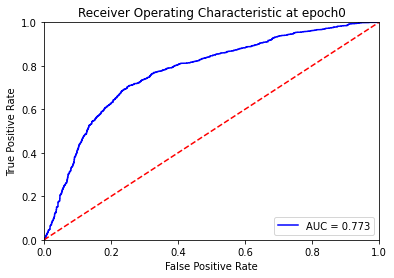



Epoch: 001, 
Train loss: 0.010394045151770115
Val loss: 0.012469511479139328,
METRICS -> CMC[@1,@3,@5]: [0.4524714946746826, 0.6064638495445251, 0.6901140809059143], MAP: 0.425503534769286, AUC: 0.7765355503048554
THRESHOLD -> Avg anchor-pos distance: 0.27553442120552063, avg anchor-neg distance: 0.27553442120552063


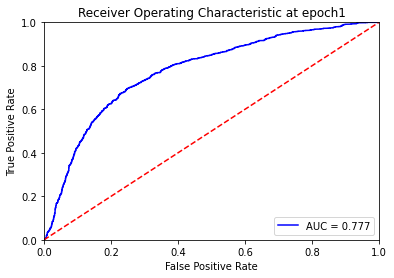



Epoch: 002, 
Train loss: 0.008818765170872211
Val loss: 0.011486507020890713,
METRICS -> CMC[@1,@3,@5]: [0.4581749141216278, 0.6045627593994141, 0.6768060922622681], MAP: 0.4264784516939363, AUC: 0.7802365330719576
THRESHOLD -> Avg anchor-pos distance: 0.3139745593070984, avg anchor-neg distance: 0.3139745593070984


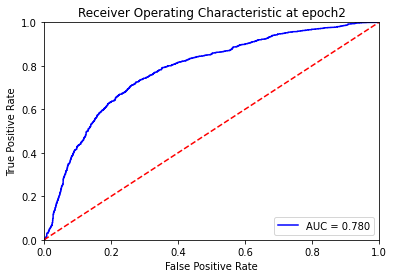



Epoch: 003, 
Train loss: 0.008081456646323204
Val loss: 0.01126017514616251,
METRICS -> CMC[@1,@3,@5]: [0.463878333568573, 0.6007604598999023, 0.6825094819068909], MAP: 0.4295922417261645, AUC: 0.7805637960078115
THRESHOLD -> Avg anchor-pos distance: 0.3437047600746155, avg anchor-neg distance: 0.3437047600746155


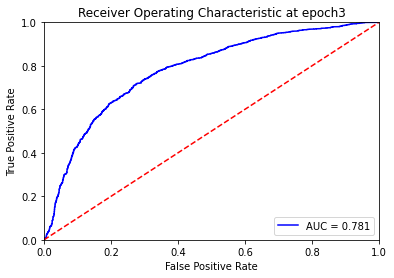



Epoch: 004, 
Train loss: 0.007518242113292217
Val loss: 0.010773555375635624,
METRICS -> CMC[@1,@3,@5]: [0.4733840227127075, 0.6045627593994141, 0.6863117814064026], MAP: 0.4329877762636554, AUC: 0.7849258266126026
THRESHOLD -> Avg anchor-pos distance: 0.36238041520118713, avg anchor-neg distance: 0.36238041520118713


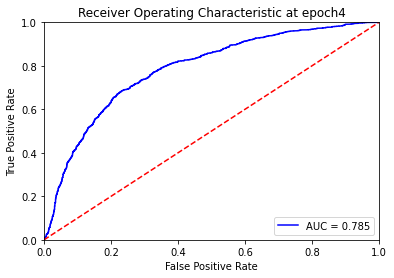



Epoch: 005, 
Train loss: 0.007333254441618919
Val loss: 0.010446774773299694,
METRICS -> CMC[@1,@3,@5]: [0.47718632221221924, 0.6007604598999023, 0.6939163208007812], MAP: 0.4347943770667594, AUC: 0.7854563186669847
THRESHOLD -> Avg anchor-pos distance: 0.36959826946258545, avg anchor-neg distance: 0.36959826946258545


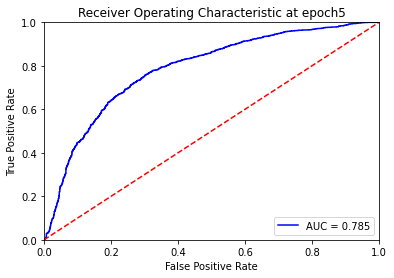



Epoch: 006, 
Train loss: 0.0070169768296182156
Val loss: 0.010415221564471722,
METRICS -> CMC[@1,@3,@5]: [0.4695817530155182, 0.5988593101501465, 0.6958174705505371], MAP: 0.4350825206533813, AUC: 0.7825029162505032
THRESHOLD -> Avg anchor-pos distance: 0.39327797293663025, avg anchor-neg distance: 0.39327797293663025


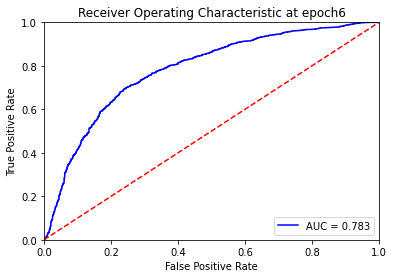



Epoch: 007, 
Train loss: 0.0067715151235461235
Val loss: 0.010282506234943867,
METRICS -> CMC[@1,@3,@5]: [0.4752851724624634, 0.6178707480430603, 0.7034220695495605], MAP: 0.43792512968464503, AUC: 0.7853576739315157
THRESHOLD -> Avg anchor-pos distance: 0.39927610754966736, avg anchor-neg distance: 0.39927610754966736


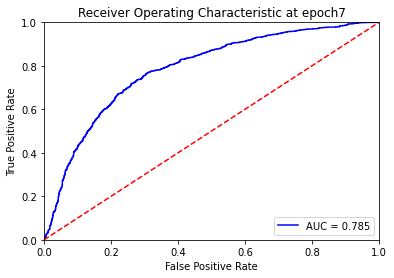



Epoch: 008, 
Train loss: 0.0064777107909321785
Val loss: 0.010264385491609573,
METRICS -> CMC[@1,@3,@5]: [0.46768060326576233, 0.6368821263313293, 0.6996197700500488], MAP: 0.4371183631530813, AUC: 0.783701793354303
THRESHOLD -> Avg anchor-pos distance: 0.4089242219924927, avg anchor-neg distance: 0.4089242219924927


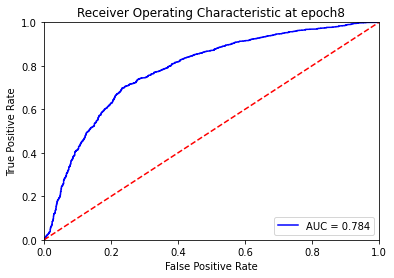



Epoch: 009, 
Train loss: 0.006420713849365711
Val loss: 0.010329089127480984,
METRICS -> CMC[@1,@3,@5]: [0.47148290276527405, 0.6330798268318176, 0.7129277586936951], MAP: 0.4393789835470007, AUC: 0.7859905375590704
THRESHOLD -> Avg anchor-pos distance: 0.40871673822402954, avg anchor-neg distance: 0.40871673822402954


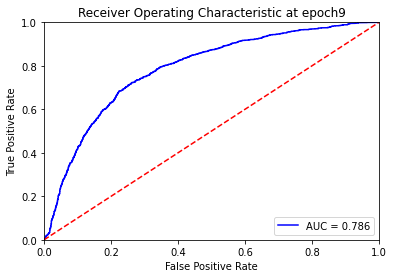

In [16]:
for epoch in range(num_epochs):
    # Training
    train_epoch(epoch, train_loader)

    # Validation
    test_epoch(epoch, val_loader, save_distances=True)

# Work in progress

This is just to display some results, but it still doesn't work, we have to run it on sagemaker, so work in progress here...

In [ ]:
# We first define a function that loads (a subset of) the results and displays them
from IPython.display import Image, display, HTML
import random
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def display_results(results_file, subset_size = 10):

  lines = None
  with open(results_file, 'rb') as f:
    lines = pickle.load(f)
  
  photos = []
  with open("/content/drive/MyDrive/Colab Notebooks/photos.pkl", "rb") as f:
    photos = pickle.load(f)
  
  k=0
  for i in range(0, 5000, 800):
    print(f'anchor id :{lines[i][0]}')
    print(f'positive id:{lines[i][1]}')
    print(f'negative id:{lines[i][2]}')
    print(f'positive distance:{lines[i][3]}')
    print(f'negative distance:{lines[i][4]}')
    
    display(Image(photos[k], width=200, height=200), Image(photos[k], width=250, height=250))
    k+=1
    display(Image(photos[k], width=200, height=200))
    k+=1
    display(Image(photos[k], width=200, height=200))
    k+=1



display_results('1_results.pkl', 30)

ValueError: ignored

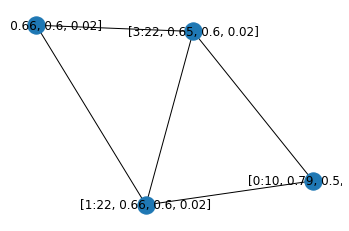

In [ ]:
g0, idx = data.get_by_photo_id('F_2020_08_23@11.02.16(225)_Converted_CROP_1_2095.jpg')
utils.display_graph(g0)
from IPython.display import display, Image
display(Image('F_2020_08_23@11.02.16(225)_Converted_CROP_1_2095.jpg'))

In [ ]:
# Little aux function for displaying what we are doing[Only in sagemaker]
import os
def get_abs_path(datas):
  ids =  [os.path.join(data.line_id, 'images', data.pylon_id, data.photo_id) for data in datas]
  return ids